In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1) # This shuffles the rows
df

,fen_value,score
215700,rnbqk1nr/ppp1bppp/3pp3/8/4P3/2NP4/PPP2PPP/R1BQ...,51
292301,3k4/1p2n2p/p4rp1/2b2p2/2B2P2/2N5/PPP3PP/3K4 b ...,457
176899,r2q1rk1/3n2pp/p1nbbp2/2p1p3/3pP3/1PpP1NPP/PBNQ...,-632
21481,rn1qkb1r/1ppb1ppp/p2ppn2/8/3PP3/3B1N2/PPP2PPP/...,-91
290907,rn1qkb1r/ppp2ppp/3p1n2/4P3/4P3/2N2b2/PPPP2PP/R...,68
...,...,...
214730,2kr3r/pppq1ppp/3b4/5b2/3Pp3/P1P1n3/1P2BPPP/RN1...,-159
261532,r2q1r1k/ppp3pp/3p4/3Q4/3nP3/8/P4PPP/R4RK1 w - ...,-90
108372,r4rk1/3bppbp/2qp1np1/2p2P2/1pP1P3/pP1P2Q1/PBNN...,-74
276375,rn1qk2r/pp3pbp/2p1p1p1/3nP3/2B2P2/2P2Q1P/PP4P1...,-62


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings)

In [7]:
X.shape, y.shape

(torch.Size([336903, 70]), torch.Size([336903]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    if bs > len(X): bs = len(X)
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.01
num_steps = 100
bs = 12800
# allowed_error = 100 #

In [13]:
model = MLPEngine(embedding_dim=32).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = lr)
# model.compile()

In [14]:
train_history = {}
val_history = {}
for step_i in range(num_steps):
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    if loss.item() < 100:
        train_history[step_i] = loss.item()
    loss.backward()
    optimiser.step()

    if step_i % 10 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        print(loss.item())
        if loss.item() < 100:
            val_history[step_i] = loss.item()

        



5631.30322265625
28.205768585205078
3.716433525085449
0.3423081636428833
0.11000849306583405
0.054585520178079605
0.03803066536784172
0.03311091288924217
0.03217490017414093
0.03220944106578827


In [15]:
val_history.values()

dict_values([28.205768585205078, 3.716433525085449, 0.3423081636428833, 0.11000849306583405, 0.054585520178079605, 0.03803066536784172, 0.03311091288924217, 0.03217490017414093, 0.03220944106578827])

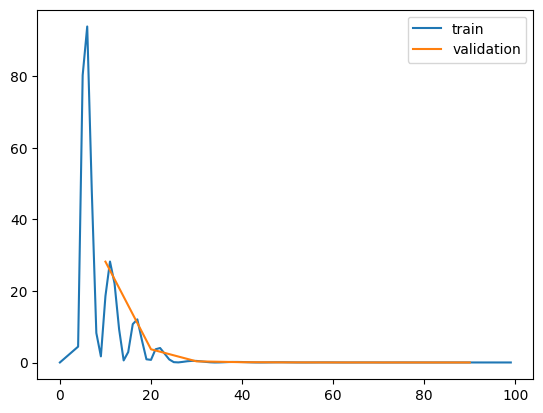

In [16]:
plt.plot(train_history.keys(), train_history.values(), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

# Inference

# TODO
- do inference
- evaluate on test dataset
- do some hyperparameter tuning, maybe grid search or something
- look for other/ better dataset
- add regularisation
- add prop initialisation
- Then start to think about architectural changes